In [248]:
import numpy as np
import matplotlib.pyplot as plt

(1) We want to find $g(x)$ such that:

$ f(x+a) = \sum_{y=0}^{N-1} f(y) g(x-y) dy $.

Let $F(k), G(k)$ be the Fourier Transforms of (the periodic extensions of) $f(x),g(x)$ respectively. Then using the properties of Fourier Transforms and the Convolution Theorem, we have:

$ F(k) e^{- \frac{2 \pi i k a}{N}} = F(k) G(k) \implies G(k) = e^{-\frac{2 \pi i k a}{N}}$

and so $g(x) = \text{IFT}\left[e^{-\frac{2 \pi i k a}{N}} \right]$. We can then get:

$f(x+a) = \text{IFT}\left[ F(k) e^{\frac{- 2 \pi i k a}{N}} \right]$ which just computes the required convolution.

This can be computed analytically, but using `np.fft.ifft` is pretty fast so that the analytic computation is unnecessary.

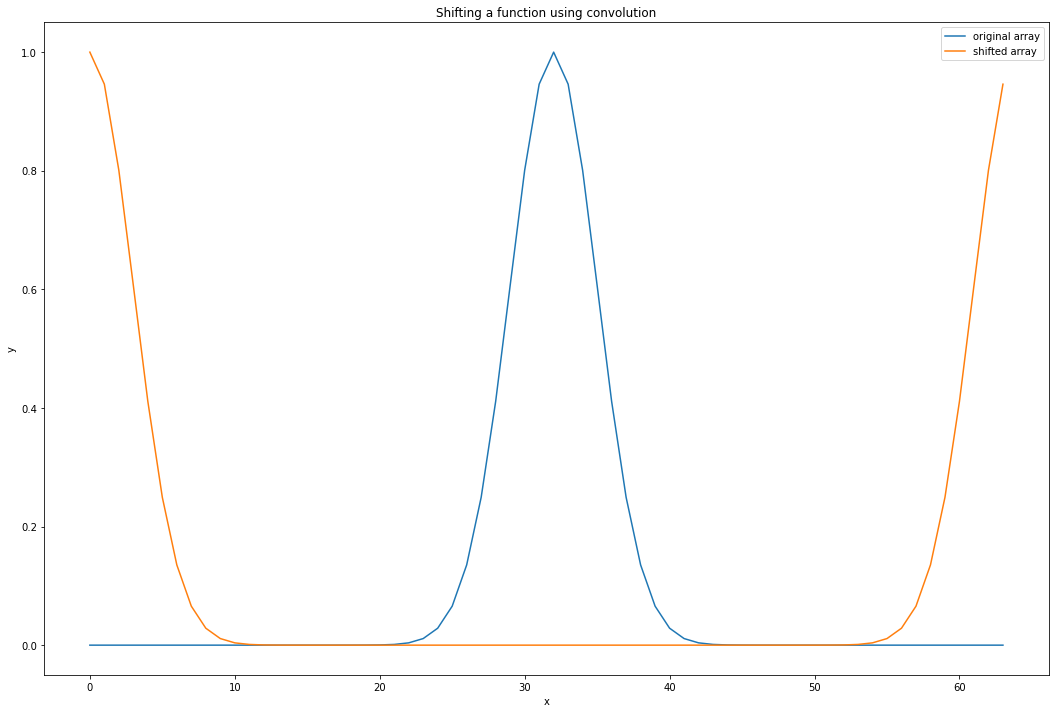

In [249]:
def convolve(f,g):
    assert(len(f)==len(g))
    N = len(f)
    c = np.zeros(N, dtype=np.complex128)
    for i in range(N):
        # shift g_array by x and sum element-wise to perform the convolution integral for each x
        c[i] = np.sum(f*np.roll(g,i))
    return c

def kernel(a,N):
    ker_hat = np.zeros(N, dtype=np.complex128)
    for i in range(N):
        ker_hat[i] = np.exp(2*np.pi*1J*i*a/N)
    return ker_hat

def gaussian(x,mean,std):
    return np.exp(-(x-mean)**2/2/std**2)

def shift_function(f, a):
    N = len(f)
    g = kernel(a,N)
    # g = np.fft.ifft(ker_hat)
    # shift = convolve(f,g)
    f_hat = np.fft.fft(f)
    shift = np.fft.ifft(f_hat * g)
    return shift

N = 64
a = N//2

x = np.arange(N)
f = gaussian(x, N//2, 3)
shift = shift_function(f,a)


plt.plot(x,f, label='original array')
plt.plot(x,np.real(shift), label='shifted array')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Shifting a function using convolution")
plt.legend()
plt.show()

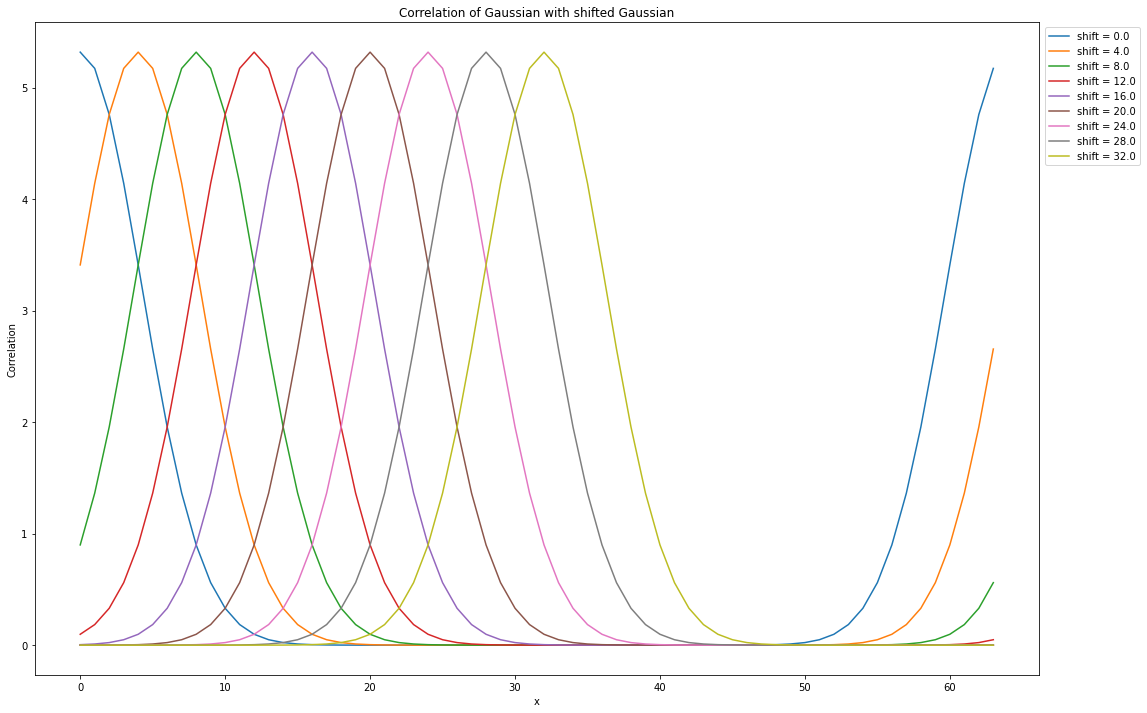

In [250]:
def correlation(f,g):
    return np.fft.ifft(np.fft.fft(f) * np.conj(np.fft.fft(g)))

list_of_shifts=np.linspace(0,N//2,9)
for a in list_of_shifts:
    corr = np.abs(correlation(f, shift_function(f,a)))
    plt.plot(x, corr, label='shift = {}'.format(a))
    
plt.legend(bbox_to_anchor=(1.001, 1))
plt.xlabel('x')
plt.ylabel('Correlation')
plt.title("Correlation of Gaussian with shifted Gaussian")
plt.show()

This is reasonable behaviour, since the correlation of two gaussians will be a gaussian, particularly since we are periodically wrapping them around. This is because the FT of a gaussian is a gaussian, and the product of two gaussians is also a gaussian, and finally doing the IFT of this gaussian returns a gaussian. We would expect that the peak of the correlation corresponds to the separation of the peaks of the input gaussians, and we see that this is indeed the case. Hence, this result makes sense!

(3)

If we have two arrays of length $N$ and $M$ respectively, we pad both arrays with zeros at the end to make the lengths $N+M-1$ and then do the convolution as before. Let's do that and see what the result looks like. In this case, since we want to avoid the wrap, we would get a resulting convolution of length $N+M-1$ as it should be.

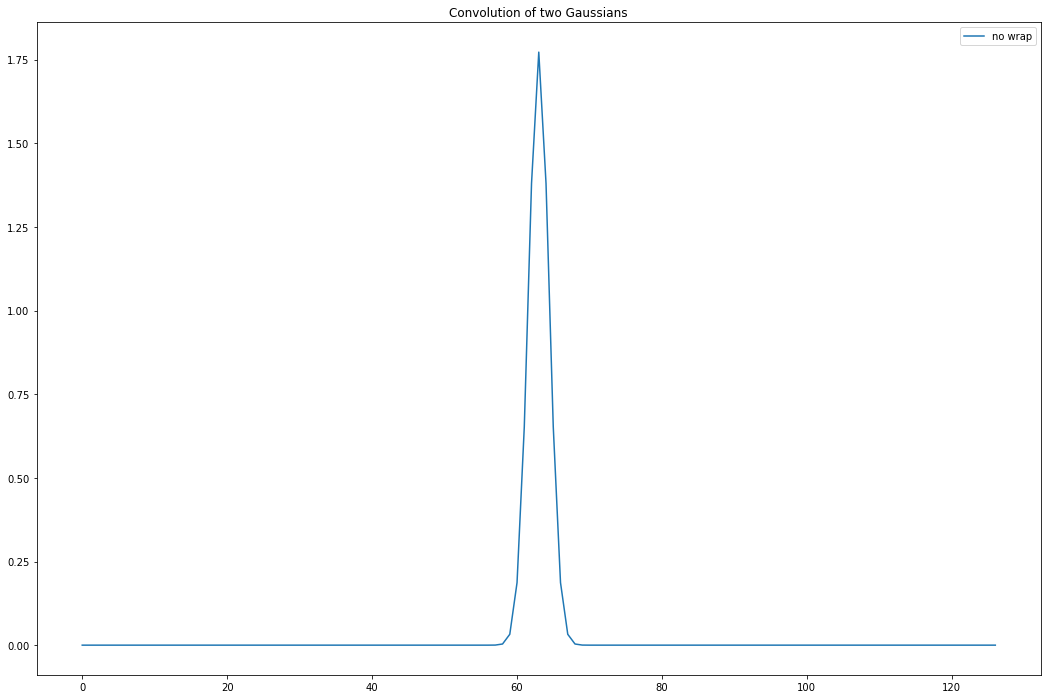

In [251]:
def convolve_wrap(f,g):
    f_hat = np.fft.fft(f)
    g_hat = np.fft.fft(g)
    return np.fft.ifft(f_hat * g_hat)

def convolve_nowrap(f,g):
    N = len(f)
    M = len(g)
    F = np.zeros(N+M-1)
    G = np.zeros(N+M-1)
    F[0:N] = f
    G[0:M] = g
    F_hat = np.fft.fft(F)
    G_hat = np.fft.fft(G)
    conv = np.fft.ifft(F_hat * G_hat)
    return conv
    

f = gaussian(x,5,1)
g = gaussian(x,58,1)
x2 = np.arange(0,127)
conv1 = np.real(convolve_wrap(f,g))
conv2 = np.real(convolve_nowrap(f,g))
plt.plot(x2,conv2, label='no wrap')
plt.title("Convolution of two Gaussians")
plt.legend()
plt.show()

(4)

(a) First, let's get an expression for the geometric sum: $ S = \Sigma_{k=N_i}^{N_f} \alpha^k $ for some real number $\alpha$. Multiply through by $\alpha$ to get the identity: $\alpha S = S - \alpha^{N_i} + \alpha^{N_f+1}$, which, upon rearranging gives:

$ S = \frac{\alpha^{N_i} - \alpha^{N_f+1}} {1 - \alpha}$.

Put $\alpha = e^{-\frac{2 \pi i k}{N}}$, $N_i = 0, N_f = N-1$ to get:

$ \Sigma_{x=0}^{N-1} e^{-\frac{2 \pi i k x}{N}} = \Sigma_{x=0}^{N-1} \left(e^{-\frac{2 \pi i k}{N}} \right)^x = \frac{1-e^{-2 \pi i k}}{1 - e^{-\frac{2 \pi i k}{N}}}$

(b) If we take the limit $k \rightarrow 0$ of the RHS expression, we get a $0/0$ result, so we can use l'Hopital's rule:

$ \lim_{k \rightarrow 0} \frac{1-e^{-2 \pi i k}}{1 - e^{-\frac{2 \pi i k}{N}}} = \lim_{k \rightarrow 0} 
\frac{\frac{d \left(1-e^{-2 \pi i k}\right)}{dk}}{\frac{d \left(1 - e^{-\frac{2 \pi i k}{N}} \right)}{dk}} 
= \frac{2 \pi i}{(2 \pi i/N)} = N $

This can also be verified by putting $k=0$ in each term of the sum, which just results in a sum on $N$ terms each of which is $1$, so $S=N$.

If $k$ is an integer but not a multiple of $N$ then the numerator in the RHS is $1 - e^{- 2 \pi i k} = 0$ since $k$ is an integer, but the denominator is $1 - e^{- \frac{2 \pi i k}{N}} \neq 0$ since $\frac{k}{N}$ is not an integer, hence the sum is zero if $k$ is an integer but not a multiple of $N$.

(c) 

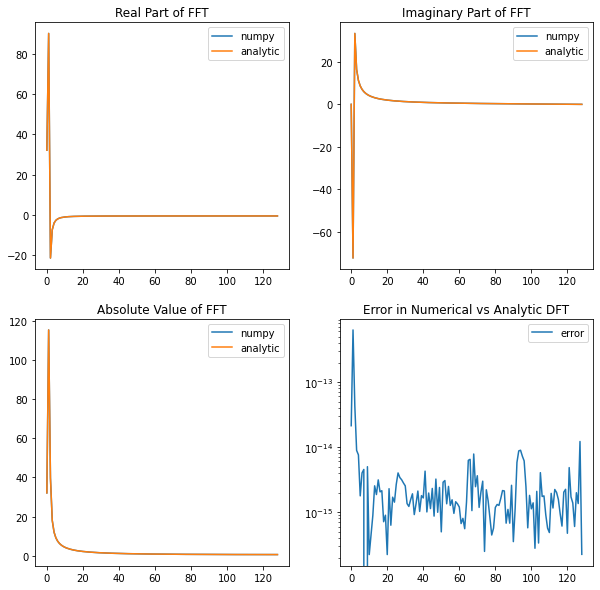

In [262]:
N = 256
alpha = 1.25
x = np.arange(0,N)
test_sin = np.sin(2 * np.pi * alpha * x/N)
fft_test = np.fft.rfft(test_sin)
k = np.arange(0,N)
analytic_test = (1/2J) * (1 - np.exp(2*np.pi*1J*alpha))/(1 - np.exp(-2*np.pi*1J*(k-alpha)/N)) - \
(1/2J)*(1 - np.exp(-2*np.pi*1J*alpha))/((1 - np.exp(-2*np.pi*1J*(k+alpha)/N)))                                                                                                                                      
analytic_test = analytic_test[0:N//2+1]
#fft_test = np.fft.fftshift(fft_test)
#analytic_test = np.fft.fftshift(analytic_test)

plt.rcParams['figure.figsize'] = (10,10)

fig, axs = plt.subplots(2,2)

ax0 = axs[0,0]
ax1 = axs[0,1]
ax2 = axs[1,0]
ax3 = axs[1,1]
ax0.plot(np.real(fft_test), label='numpy')
ax0.plot(np.real(analytic_test), label = 'analytic')
ax0.legend()
ax0.set_title("Real Part of FFT")
ax1.plot(np.imag(fft_test), label='numpy')
ax1.plot(np.imag(analytic_test), label = 'analytic') 
ax1.set_title("Imaginary Part of FFT")
ax1.legend()
ax2.plot(np.abs(fft_test), label='numpy')
ax2.plot(np.abs(analytic_test), label = 'analytic')  
ax2.legend()
ax2.set_title("Absolute Value of FFT")
ax3.semilogy(np.abs(fft_test-analytic_test), label='error')
ax3.legend()
ax3.set_title("Error in Numerical vs Analytic DFT")
plt.show()




0.5
122.96358974253666
115.55894507819848


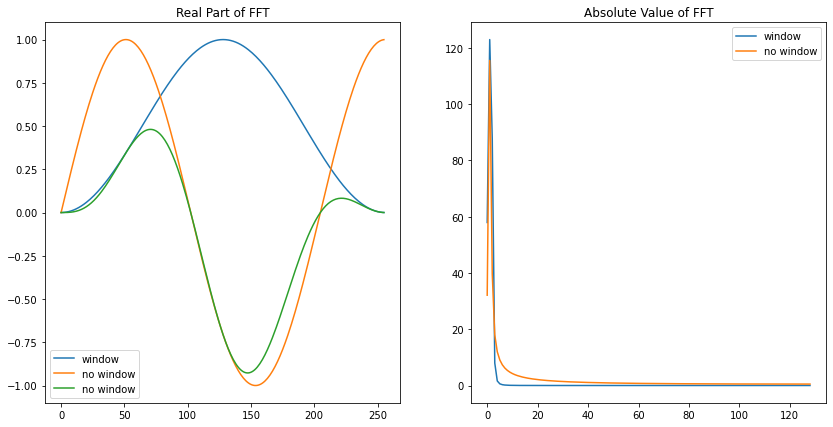

In [253]:
window = 0.5 - 0.5*np.cos(2*np.pi*x/N)
window_test_sin = np.sin(2 * np.pi * alpha * x/N) * window
normfac = np.mean(window)
#normfac=1
print(normfac)
fft_window_test = np.fft.rfft(window_test_sin)/normfac
print(np.max(np.abs(fft_window_test)))
print(np.max(np.abs(fft_test)))
#fft_window_test = np.fft.fftshift(fft_window_test)

plt.rcParams['figure.figsize'] = (14,7)
fig, axs = plt.subplots(1,2)

ax0 = axs[0]
ax1 = axs[1]
ax0.plot(window, label='window')
ax0.plot(np.sin(2*np.pi*alpha*x/N), label = 'no window')
ax0.plot(window*np.sin(2*np.pi*alpha*x/N), label = 'no window')
ax0.legend()
ax0.set_title("Real Part of FFT")
ax1.plot(np.abs(fft_window_test), label='window')
ax1.plot(np.abs(fft_test), label = 'no window')  
ax1.legend()
ax1.set_title("Absolute Value of FFT")
plt.show()

As we can see, the peak is much more localized when the window is applied and it has a slightly higher power just as we wanted! The orange curve has a peak that is more spread out which is because of the difference between the value of `sin(x)` at `x=0` and `x=N-1` which the FFT algorithm interprets as a discontinuity when doing the periodic extension.

(e) Let $f(x) = \frac{1}{2} - \frac{1}{2} \cos\left(\frac{2 \pi x}{N}\right)$ and $F(k)$ its DFT. Then:

$F(k) = \sum_{x=0}^{N-1} \left[  \frac{1}{2} - \frac{1}{2} \cos\left(\frac{2 \pi x}{N}\right) \right] e^{-\frac{2 \pi i k x}{N}} = \frac{1}{2} \sum_{x=0}^{N-1} e^{-\frac{2 \pi i k x}{N}} - \frac{1}{4}  \sum_{x=0}^{N-1} \left[ e^{\left(\frac{2 \pi i x}{N}\right)} + e^{\left(- \frac{2 \pi i x}{N}\right)} \right] e^{-\frac{2 \pi i k x}{N}} $.

Using the formula for the geometric sum derived above:

$ F(k) = \frac{1}{2} \left( \frac{1 - e^{-2 \pi i k}}{1 - e^{- \frac{2 \pi i k}{N}}} \right) - \frac{1}{4} \left( \frac{1 - e^{-2 \pi i (k-1)}}{1 - e^{- \frac{2 \pi i (k-1)}{N}}} \right) - \frac{1}{4} \left( \frac{1 - e^{-2 \pi i (k+1)}}{1 - e^{- \frac{2 \pi i (k+1)}{N}}} \right) $

Considering that $k \in [0,1,2,...,N-1]$, and the observations made in part (b), this is non-zero only when one of $k, k \pm 1$ is either zero or a multiple of N. This can happen only when $k = 0, k-1 = 0 \implies k = 1$ or $k+1 = N \implies k = N-1$ for the $k$-values in the given range. When $k=0$, the first term above is $\frac{N}{2}$, the rest being zero. When $k = 1$, the second term is $\frac{-N}{4}$, the rest being zero and when $k=N-1$, the third term is $\frac{-N}{4}$, the rest being zero. At all other $k$ values, the sum evaluates to just zero. Hence as an array, `F(k) = [N/2 -N/4 0 0 ... 0 0 -N/4]`.

Next, suppose we are given a function $g(x)$ with unwindowed FT $G(k)$. We wish to compute the windowed Fourier Transform (WFT) of $g(x) f(x)$ with the $f(x)$ above. By using the Convolution Theorem in reverse, we get:

$ WFT(k) = \frac{1}{N}\sum_{k' = 0}^{N-1} F(k') G(k-k')$ where I have discretized the convolution integral and used $\Delta k = 1$.

Now $F(k') = \frac{N}{2} \delta_{k', 0} - \frac{N}{4} \delta_{k',1} - \frac{N}{4} \delta_{k', N-1}$, which implies:

$WFT(k) = \frac{1}{2} G(k) - \frac{1}{4} G(k-1) - \frac{1}{4} G(k + 1 - N) = \frac{1}{2} G(k) - \frac{1}{4} G(k-1) - \frac{1}{4} G(k + 1) $

since $G(k-N) = G(k)$. In the above formula, `k[N] = k[0] and k[-1] = k[N-1]`, which would be necessary when dealing with the end points. This is the required linear combination of immediate neighbors that we were looking for.

(5) First I write down all the directory paths of the data files from the detectors and the template files for each event, and I make lists of the file names, that I will later pass as arguments to function calls to run the analysis on each data set.

In [254]:
import h5py
import glob

In [255]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

hnames=glob.glob("./LOSC_Event_tutorial/[H]-*.hdf5")  # Hanford events
lnames=glob.glob("./LOSC_Event_tutorial/[L]-*.hdf5")  # Livingston events

tnames=[] 
tnames.append('./LOSC_Event_tutorial/GW151226_4_template.hdf5')
tnames.append('./LOSC_Event_tutorial/LVT151012_4_template.hdf5')
tnames.append('./LOSC_Event_tutorial/GW150914_4_template.hdf5')
tnames.append('./LOSC_Event_tutorial/GW170104_4_template.hdf5')  # Templates in correct order

events = []
events.append('GW151226')
events.append('LVT151012')
events.append('GW150914')
events.append('GW170104')  # Event names in correct order

The idea behind the analysis largely follows the approach from class. First I read in the data from the file names above. Then I separately analyze the Hanford and Livingston data for each event. The analysis is as follows:

(1) Make window function for FFT, the window function is plotted below. I got the idea for this function from the git of the 2021 version of this course.
(2) Make array of correct frequencies
(3) Estimate noise in the data by first multiplying data by window and then taking the Fourier transform, multiplying it by the FT of a gaussian of some width, and then taking the IFT. 

I played around with this and decided on 10 pixels since that seemed to be sufficiently small to the able to resolve some of the noise spikes (spectral lines) in the mid-frequency portion, which is what I wanted, but still large enough to be sufficiently smooth out the noise and very low and very high frequencies. I choose 20 Hz and 1700 Hz as the cutoff at the low and high end of the frequency for the noise. This was motivated by the fact that the noise got very large for $\nu < 20$ Hz and it got too small at $\nu > 1700 Hz$ both of which are undesired. We do not expect there to be significant contributions to the signal outside the bounds of these frequencies and so we reduce their weight to 0 in the curve fits.

(4) Multiply template by window and then proceed to do the curve fit procedure for $m(\tau)$ as described in class, i.e. compute:

$ m = \frac{ \text{IFT} \left[ \text{conj}\{\text{FT}[(N^{-1/2}A)^T]\}\text{FT}[N^{-1/2} d] \right]}{(N^{-1/2}A)^T \cdot (N^{-1/2}A)} $

(5) Compute the amplitude of `m` using `np.max(np.abs(m))` and then use `np.std(whitened_data)` to compute the numerical noise and:

$ \frac{1}{\sqrt{\text{len}(A) * [\text{RHS denominator from (4)}]}}$ to get the analytic estimate of the noise and used these to find the SNR. Note, in part (4) normalizing the noise was unnecessary since the denominator and numerator cause cancellations. To get the correct analytical results though, the normalization must be used. Also, for both detectors combined, the SNR simply add in quadrature: $\text{combined SNR} = \sqrt{\text{(SNR_Hanford)}^2 + \text{(SNR_Livingston)}^2}$

(6) To get the weights of each frequency, I used $|\text{FT}[N^{-1/2} A](k)|^2$ (which is the whitened template power spectrum) and took a weighed average of the frequency $\nu$ to get the point below which and above which there is half the weight contribution. I could have done a cumulative sum but this works just as well. I also tried using the $RHS$ of the curve fit above but that again gave effectively the same result.

(7) Find the location of the maximum of the matched filter output, and zoom in on this output. Here I found that each of the peaks was about 20 pixels wide. I could in principle try to fit a Gaussian to each peak to make this part more robust, but here I decided to just inspect the plots and use some reasonable value. Using this, I have that the difference in time of arrival $dt$ = |(location of peak_Hanford - location of peak_Livingston)| and the uncertainty in this difference is $ \sigma_{dt} = \sqrt{\text{(peak_Hanford_width)}^2 + \text{(peak_Livingston_width)}^2}$.

For positional uncertainty, I interpreted that as angular position uncertainty, which, if L is the distance between the detectors, and $\theta$ the angle that the source makes with one of the detectors (the one slightly closer to the source) then we can, as a crude approximation, put $ L (\theta-\frac{\pi}{2}) \approx c dt $ and so $\delta \theta \approx \frac{\delta(dt)}{L}$, which is then computed along with $\theta$ and printed. I used the image drawn by Rigel on the Slack for this. I've also included it below!

(8) Print results and Plot stuff.

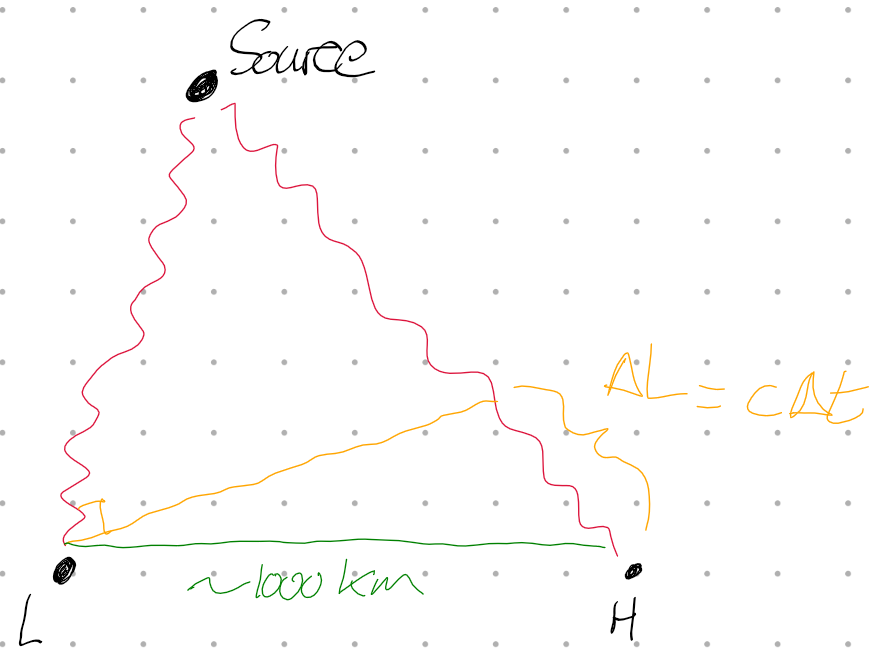

In [256]:
from IPython.display import Image

Image(filename="./rigel_drawing.png", width=800, height=800)

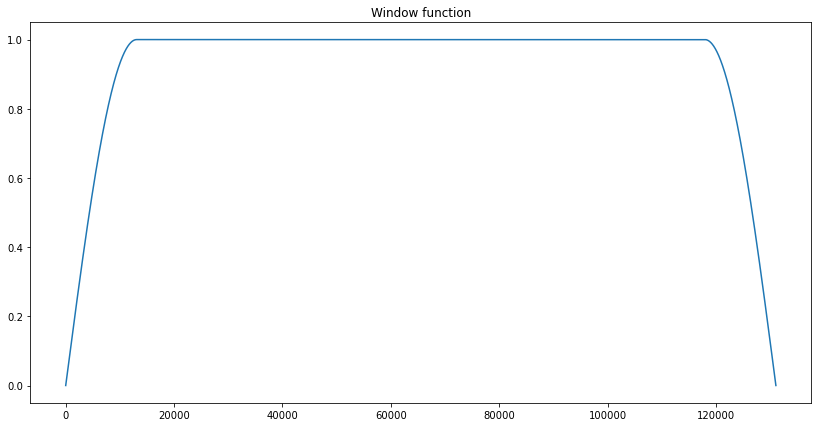

In [257]:
def make_cos_window(m):
    x = np.linspace(-np.pi/2, np.pi/2, m)
    return np.cos(x)

def window(length, m):
    w = np.ones(length)
    mm = m//2
    tmp = make_cos_window(m)
    w[:mm] = tmp[:mm]
    w[-mm:] = tmp[-mm:]
    return w

def smooth_vector(vec,sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

def get_smooth_noise(data, window, tobs):
    
    noise_ft = np.fft.fft(data*window)
    N = len(noise_ft)
    noise_smooth=smooth_vector(np.abs(noise_ft)**2, 10)
    noise_smooth=noise_smooth[:N//2+1] #will give us same length
    
    dnu=1/tobs
    nu=np.arange(len(noise_smooth))*dnu
    nu[0]=0.5*nu[1]
    Ninv = 1/noise_smooth
    Ninv[nu>1700] = 0
    Ninv[nu<20] = 0
    
    return noise_smooth, Ninv

def num_SNR(data):
    amp = np.max(np.abs(data))
    std = np.std(data)
    return amp/std
    
def ligo_analysis(hname, lname, tname, event):
    strain_h, dt_h, utc_h = read_file(hname)
    strain_l, dt_l, utc_l = read_file(lname)
    tp, tx = read_template(tname)
    assert(dt_h == dt_l)
    assert(len(strain_h) == len(strain_l))
    dt = dt_h
    N = len(strain_h)
    
    win = window(N, N//5)
    tobs=dt*N
    dnu=1/tobs
    nu=np.arange(N//2+1)*dnu
    nu[0]=0.5*nu[1]
    
    hnoise_smooth, hNinv = get_smooth_noise(strain_h, win, tobs)
    lnoise_smooth, lNinv = get_smooth_noise(strain_l, win, tobs)
    
    temp = tp*win
    hsqrtPS = np.sqrt(hNinv)
    htemp_bar_ft = hsqrtPS * np.fft.rfft(temp)
    hdata_bar_ft = hsqrtPS * np.fft.rfft(strain_h*win)  
    hdata_bar = np.fft.irfft(hdata_bar_ft)  # whitened data
    htemp_bar = np.fft.irfft(htemp_bar_ft)  # whitened template
    hrhs = np.fft.irfft(hdata_bar_ft * np.conj(htemp_bar_ft))
    hlhs = np.sum(htemp_bar**2)
    hm = hrhs/hlhs
    h_amp = np.max(np.abs(hm))
    h_scatter_noise = np.std(hm)
    h_analytic_noise = 1/np.sqrt(N * hlhs)
    h_analyticSNR = h_amp/h_analytic_noise
    h_numericalSNR = h_amp/h_scatter_noise
    hweights = np.abs(htemp_bar_ft)**2
    h_midpoint = np.sum(nu*hweights)/np.sum(hweights)
    
    
    lsqrtPS = np.sqrt(lNinv)
    ltemp_bar_ft = lsqrtPS * np.fft.rfft(temp)
    ldata_bar_ft =lsqrtPS * np.fft.rfft(strain_l*win)
    ldata_bar = np.fft.irfft(ldata_bar_ft)  # whitened data
    ltemp_bar = np.fft.irfft(ltemp_bar_ft)  # whitened template
    lrhs = np.fft.irfft(ldata_bar_ft * np.conj(ltemp_bar_ft))
    llhs = np.sum(ltemp_bar**2)
    lm = lrhs/llhs
    l_amp = np.max(np.abs(lm))
    l_scatter_noise = np.std(lm)
    l_analytic_noise = 1/np.sqrt(N*llhs)
    l_analyticSNR = l_amp/l_analytic_noise
    l_numericalSNR = l_amp/l_scatter_noise
    
    lweights = np.abs(ltemp_bar_ft)**2
    l_midpoint = np.sum(nu*lweights)/np.sum(lweights)
    
    hind = np.argmax(np.abs(np.fft.fftshift(hm)))
    lind = np.argmax(np.abs(np.fft.fftshift(lm)))
    delta_t = (hind-lind)*dt
    sigma_delta_t = np.sqrt(2)*20*dt
    L = 1E3
    
    print("Event: ", event)
    print("Analytic SNR for Hanford: ", h_analyticSNR)
    print("Numerical SNR for Hanford: ", h_numericalSNR)
    print("Analytic SNR for Livingston: ", l_analyticSNR)
    print("Numerical SNR for Livingston: ", l_numericalSNR)
    
    print("\nAnalytic SNR for Hanford+Livingston: ", np.sqrt(h_analyticSNR**2 + l_analyticSNR**2))
    print("Numerical SNR for Hanford+Livingston: ", np.sqrt(h_numericalSNR**2 + l_numericalSNR**2))
    
    print("\nFrequency at which half-weight occurs for Hanford:",h_midpoint)
    print("Frequency at which half-weight occurs for Livingston:",l_midpoint)
    
    print("\nDifference in time of arrival: ", np.abs(delta_t), "+/-", sigma_delta_t, "seconds")
    angle = 3E5 * delta_t/L + np.pi/2
    angle_error = 3E5 * sigma_delta_t/L
    print("Source Angle Theta =", angle, "+/-", angle_error, "radians")
    
    
    plt.rcParams['figure.figsize'] = (18,12)
    fig, axs = plt.subplots(3,2)
    ax0 = axs[0,0]
    ax1 = axs[0,1]
    ax2 = axs[1,0]
    ax3 = axs[1,1]
    ax4 = axs[2,0]
    ax5 = axs[2,1]
    plt.suptitle("Event: {}".format(event))
    ax0.plot(np.fft.fftshift(hm))
    ax0.set_title("Hanford detector - Matched Filter")
    ax1.plot(np.fft.fftshift(lm))
    ax1.set_title("Livingston detector - Matched Filter")
    ax2.plot(np.fft.fftshift(hm))
    ax2.plot(np.fft.fftshift(lm))
    ax2.set_title("Both detectors superposed - Matched Filter")
    ax3.plot(np.fft.fftshift(hm), label = 'Hanford')
    ax3.plot(np.fft.fftshift(lm), label = 'Livingston')
    ax3.set_title("Zoom in on GW event")
    ax3.set_xlim(hind-100,hind+100)
    ax3.legend()
    ax4.loglog(nu, hNinv)
    ax4.set_title("Smoothed Ninv vs Frequency - Hanford")
    ax5.loglog(nu, lNinv)
    ax5.set_title("Smoothed Ninv vs Frequency - Livingston")

    plt.show()
    
    return lm, hm

strain_h, dt_h, utc_h = read_file(hnames[0])
N = len(strain_h)
win = window(N,N//5)
plt.plot(win, label="window")
plt.title("Window function")
plt.show()

Event:  GW151226
Analytic SNR for Hanford:  10.066953566277437
Numerical SNR for Hanford:  10.310540828470273
Analytic SNR for Livingston:  7.414422495047095
Numerical SNR for Livingston:  7.536734992710215

Analytic SNR for Hanford+Livingston:  12.502688312544883
Numerical SNR for Hanford+Livingston:  12.771437919274991

Frequency at which half-weight occurs for Hanford: 106.47204645376975
Frequency at which half-weight occurs for Livingston: 143.5601289981947

Difference in time of arrival:  0.001220703125 +/- 0.006905339660024878 seconds
Source Angle Theta = 1.9370072642948966 +/- 2.0716018980074637 radians


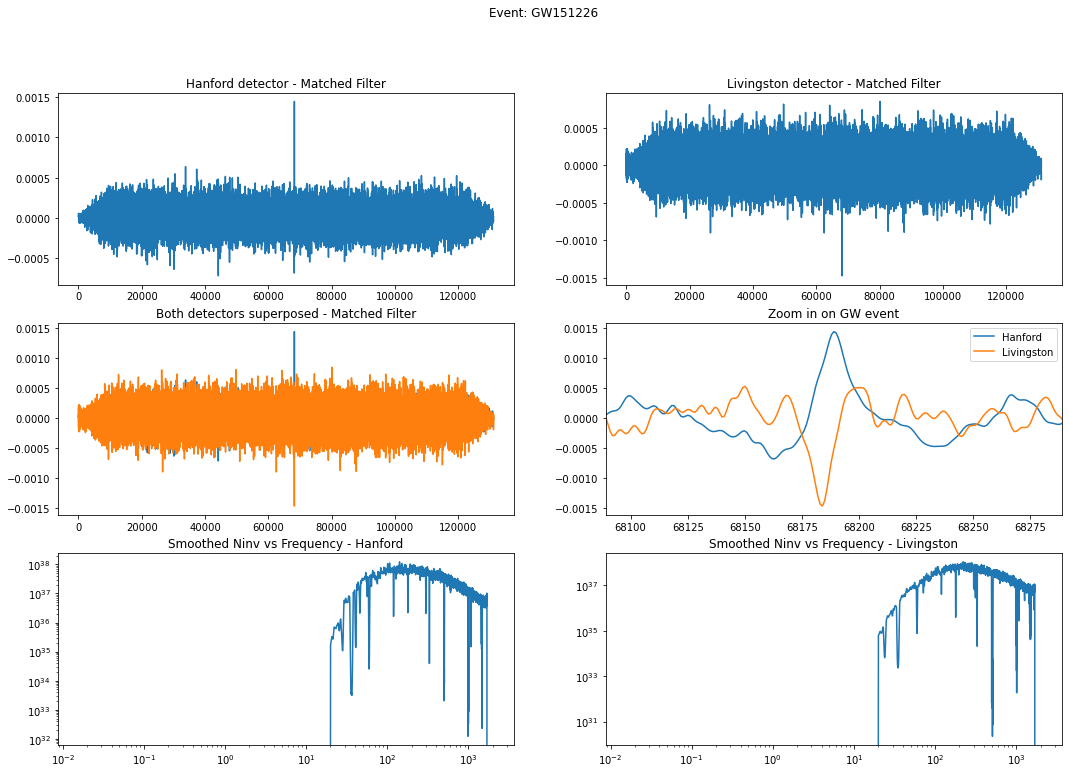

In [258]:
l0, h0 = ligo_analysis(hnames[0], lnames[0], tnames[0], events[0])

Event:  LVT151012
Analytic SNR for Hanford:  6.245412485389695
Numerical SNR for Hanford:  6.373810939757079
Analytic SNR for Livingston:  5.30977246237494
Numerical SNR for Livingston:  5.399783121253066

Analytic SNR for Hanford+Livingston:  8.19749112319475
Numerical SNR for Hanford+Livingston:  8.353629370060448

Frequency at which half-weight occurs for Hanford: 102.38315490948335
Frequency at which half-weight occurs for Livingston: 116.43175972006689

Difference in time of arrival:  0.00048828125 +/- 0.006905339660024878 seconds
Source Angle Theta = 1.4243119517948966 +/- 2.0716018980074637 radians


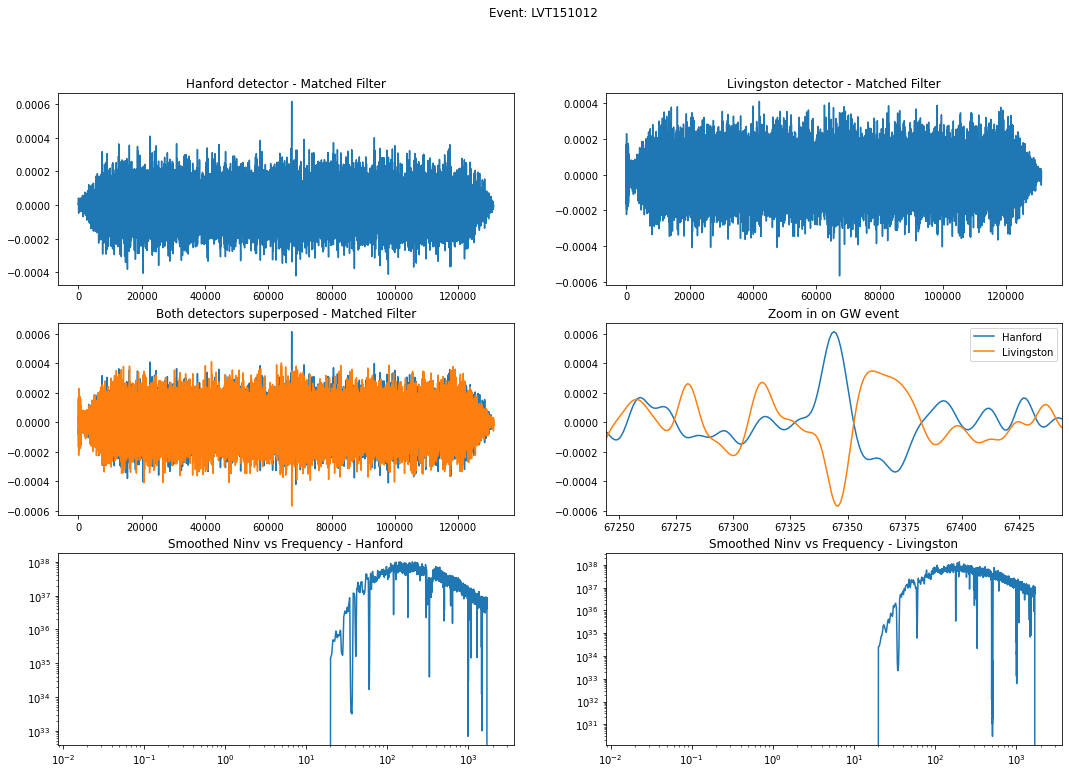

In [259]:
l1, h1 = ligo_analysis(hnames[1], lnames[1], tnames[1], events[1])

Event:  GW150914
Analytic SNR for Hanford:  18.268676468255496
Numerical SNR for Hanford:  18.60687938287024
Analytic SNR for Livingston:  13.690602409457092
Numerical SNR for Livingston:  13.910878146143205

Analytic SNR for Hanford+Livingston:  22.829304287157427
Numerical SNR for Hanford+Livingston:  23.232057402768405

Frequency at which half-weight occurs for Hanford: 117.28547496257306
Frequency at which half-weight occurs for Livingston: 126.01256435757945

Difference in time of arrival:  0.00732421875 +/- 0.006905339660024878 seconds
Source Angle Theta = 3.7680619517948966 +/- 2.0716018980074637 radians


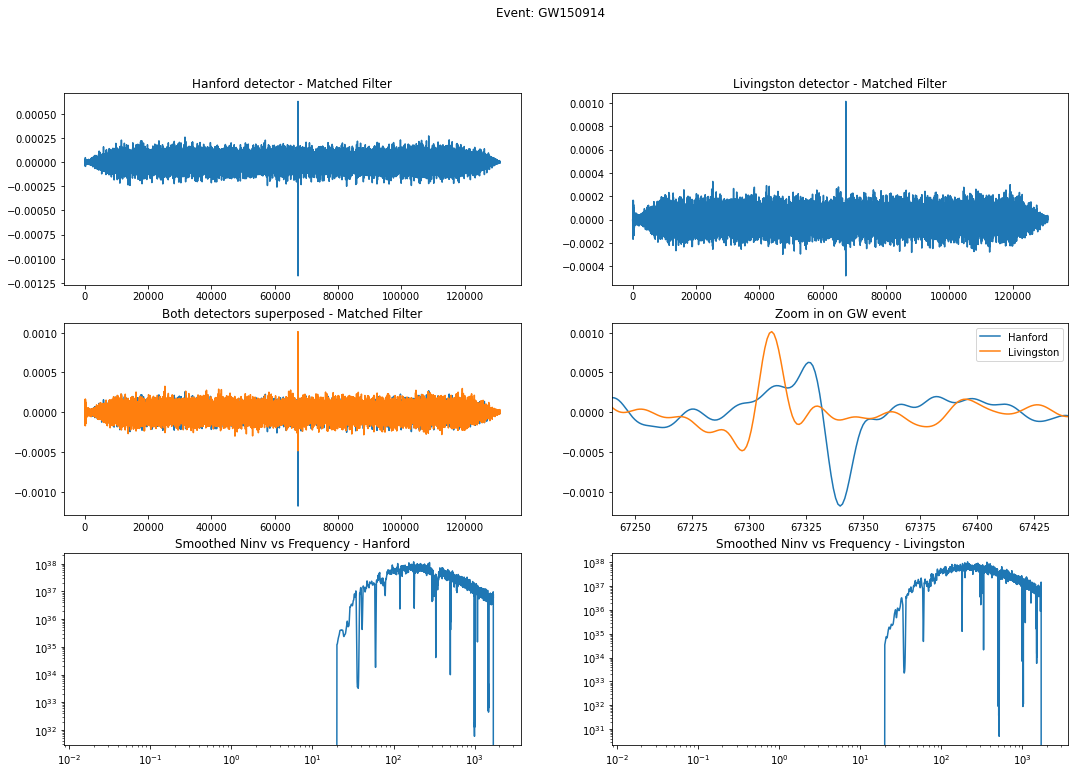

In [260]:
l2, h2 = ligo_analysis(hnames[2], lnames[2], tnames[2], events[2])

Event:  GW170104
Analytic SNR for Hanford:  8.115002443937234
Numerical SNR for Hanford:  8.28472092610954
Analytic SNR for Livingston:  9.827636565071895
Numerical SNR for Livingston:  9.975800289747962

Analytic SNR for Hanford+Livingston:  12.745026681817713
Numerical SNR for Hanford+Livingston:  12.967389569394946

Frequency at which half-weight occurs for Hanford: 117.78016267360123
Frequency at which half-weight occurs for Livingston: 101.01442834494154

Difference in time of arrival:  0.003173828125 +/- 0.006905339660024878 seconds
Source Angle Theta = 0.6186478892948966 +/- 2.0716018980074637 radians


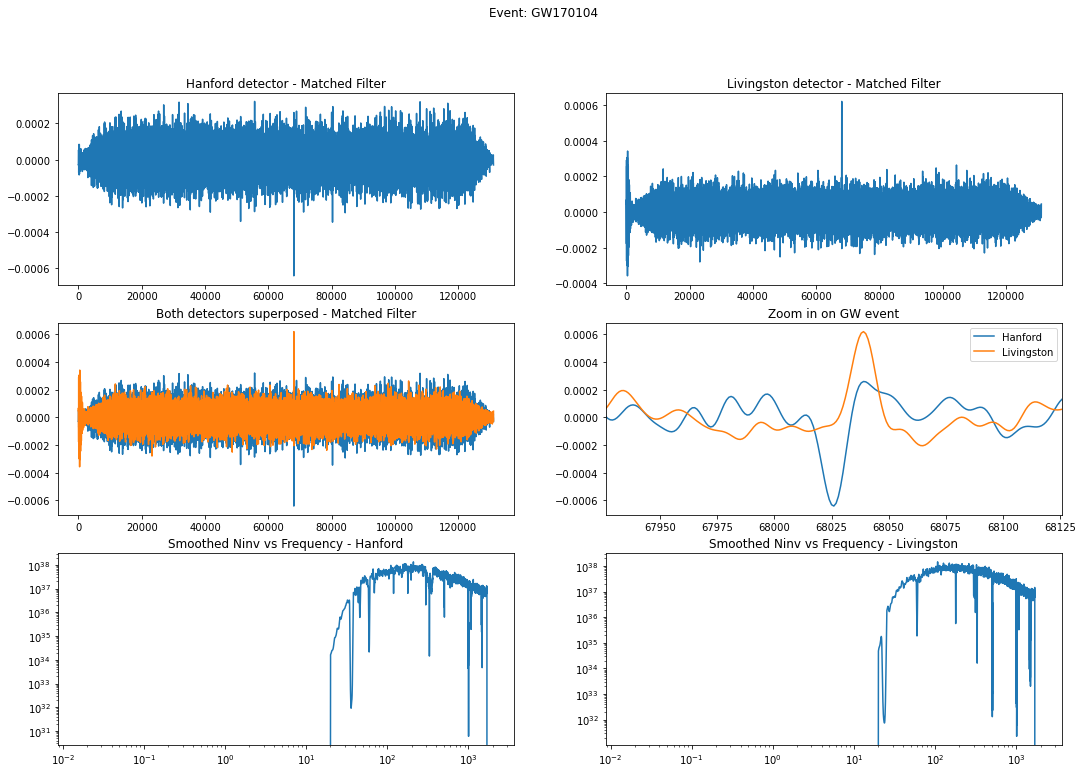

In [261]:
l3, h3 = ligo_analysis(hnames[3], lnames[3], tnames[3], events[3])